# Plotting with Pandas

matplotlib is a relatively *low-level* plotting package, relative to others. It makes very few assumptions about what constitutes good layout (by design), but has a lot of flexiblility to allow the user to completely customize the look of the output.

On the other hand, Pandas includes methods for DataFrame and Series objects that are relatively high-level, and that make reasonable assumptions about how the plot should look.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set some Pandas options
pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 25)

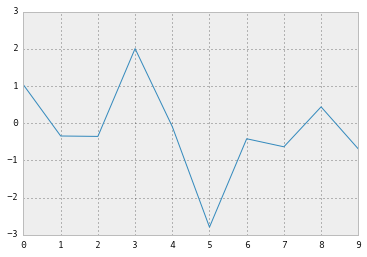

In [2]:
normals = pd.Series(np.random.normal(size=10))
normals.plot()

Notice that by default a line plot is drawn, and a light grid is included. All of this can be changed, however:

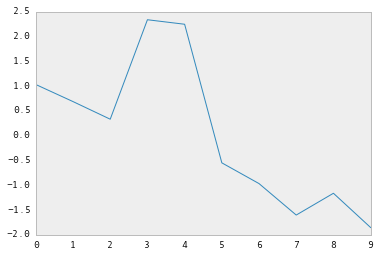

In [3]:
normals.cumsum().plot(grid=False)

Similarly, for a DataFrame:

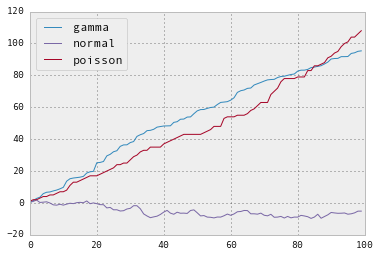

In [4]:
variables = pd.DataFrame({'normal': np.random.normal(size=100), 
                       'gamma': np.random.gamma(1, size=100), 
                       'poisson': np.random.poisson(size=100)})
variables.cumsum(0).plot()

As an illustration of the high-level nature of Pandas plots, we can split multiple series into subplots with a single argument for `plot`:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x107630a90>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1076d7850>], dtype=object)

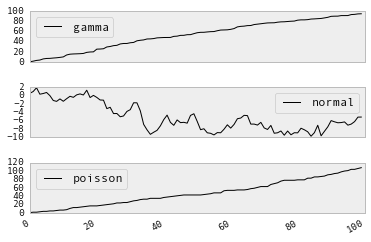

In [6]:
variables.cumsum(0).plot(subplots=True, grid=False)

Or, we may want to have some series displayed on the secondary y-axis, which can allow for greater detail and less empty space:

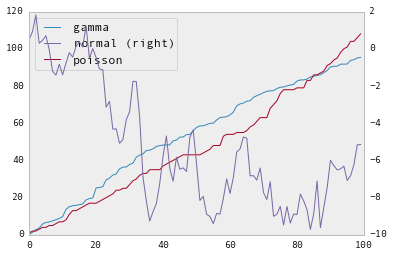

In [7]:
variables.cumsum(0).plot(secondary_y='normal', grid=False)

If we would like a little more control, we can use matplotlib's `subplots` function directly, and manually assign plots to its axes:

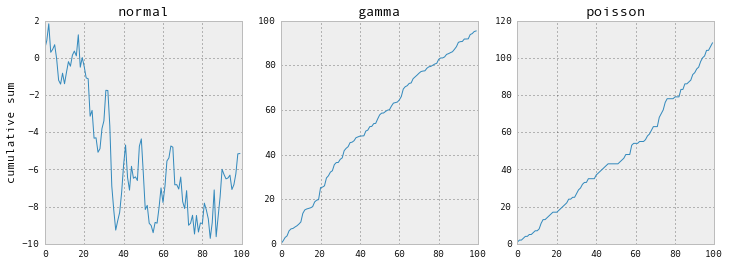

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i,var in enumerate(['normal','gamma','poisson']):
    variables[var].cumsum(0).plot(ax=axes[i], title=var)
axes[0].set_ylabel('cumulative sum')

## Bar plots

Bar plots are useful for displaying and comparing measurable quantities, such as counts or volumes. In Pandas, we just use the `plot` method with a `kind='bar'` argument.

For this series of examples, let's load up the Titanic dataset:

In [9]:
titanic = pd.read_excel("../data/titanic.xls", "titanic")
titanic.head()

   pclass  survived                                             name     sex  \
0       1         1                    Allen, Miss. Elisabeth Walton  female   
1       1         1                   Allison, Master. Hudson Trevor    male   
2       1         0                     Allison, Miss. Helen Loraine  female   
3       1         0             Allison, Mr. Hudson Joshua Creighton    male   
4       1         0  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female   

       age  sibsp  parch  ticket      fare    cabin embarked boat  body  \
0  29.0000      0      0   24160  211.3375       B5        S    2   NaN   
1   0.9167      1      2  113781  151.5500  C22 C26        S   11   NaN   
2   2.0000      1      2  113781  151.5500  C22 C26        S  NaN   NaN   
3  30.0000      1      2  113781  151.5500  C22 C26        S  NaN   135   
4  25.0000      1      2  113781  151.5500  C22 C26        S  NaN   NaN   

                         home.dest  
0                     St Louis,

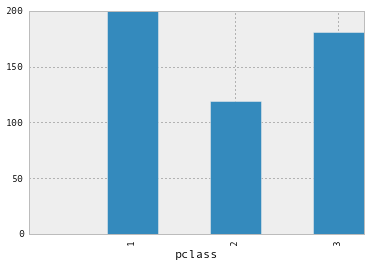

In [10]:
titanic.groupby('pclass').survived.sum().plot(kind='bar')

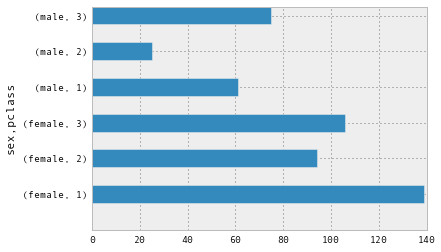

In [11]:
titanic.groupby(['sex','pclass']).survived.sum().plot(kind='barh')

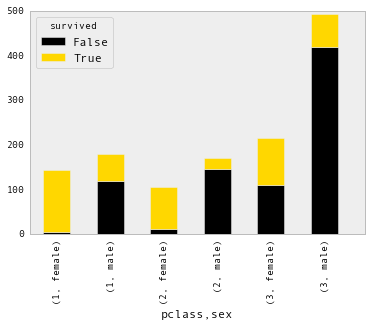

In [12]:
death_counts = pd.crosstab([titanic.pclass, titanic.sex], titanic.survived.astype(bool))
death_counts.plot(kind='bar', stacked=True, color=['black','gold'], grid=False)

Another way of comparing the groups is to look at the survival *rate*, by adjusting for the number of people in each group.

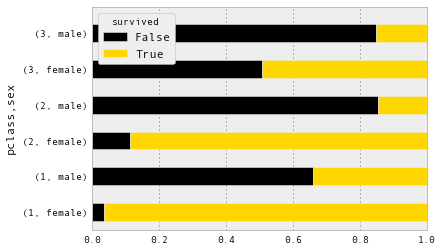

In [13]:
death_counts.div(death_counts.sum(1).astype(float), axis=0).plot(kind='barh', stacked=True, color=['black','gold'])

## Histograms

Frequenfly it is useful to look at the *distribution* of data before you analyze it. Histograms are a sort of bar graph that displays relative frequencies of data values; hence, the y-axis is always some measure of frequency. This can either be raw counts of values or scaled proportions.

For example, we might want to see how the fares were distributed aboard the titanic:

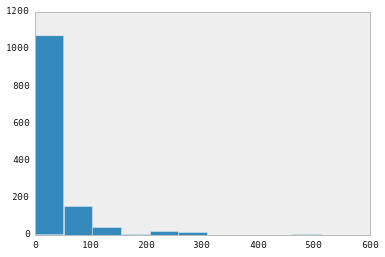

In [16]:
titanic.fare.hist(grid=False)

The `hist` method puts the continuous fare values into **bins**, trying to make a sensible décision about how many bins to use (or equivalently, how wide the bins are). We can override the default value (10):

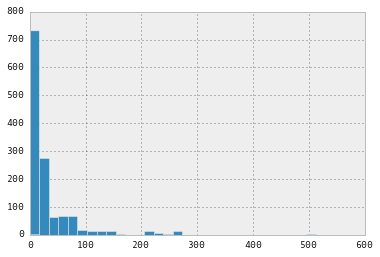

In [17]:
titanic.fare.hist(bins=30)

There are algorithms for determining an "optimal" number of bins, each of which varies somehow with the number of observations in the data series.

In [18]:
sturges = lambda n: int(np.log2(n) + 1)
square_root = lambda n: int(np.sqrt(n))
from scipy.stats import kurtosis
doanes = lambda data: int(1 + np.log(len(data)) + np.log(1 + kurtosis(data) * (len(data) / 6.) ** 0.5))

n = len(titanic)
sturges(n), square_root(n), doanes(titanic.fare.dropna())

(11, 36, 14)

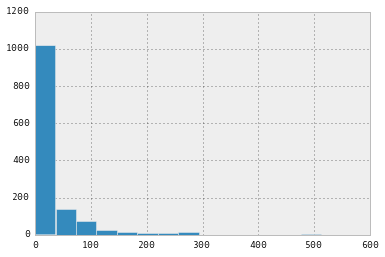

In [19]:
titanic.fare.hist(bins=doanes(titanic.fare.dropna()))

A **density plot** is similar to a histogram in that it describes the distribution of the underlying data, but rather than being a pure empirical representation, it is an *estimate* of the underlying "true" distribution. As a result, it is smoothed into a continuous line plot. We create them in Pandas using the `plot` method with `kind='kde'`, where `kde` stands for **kernel density estimate**.

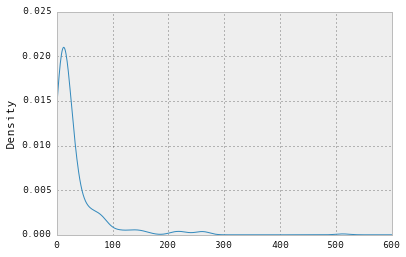

In [20]:
titanic.fare.dropna().plot(kind='kde', xlim=(0,600))

Often, histograms and density plots are shown together:

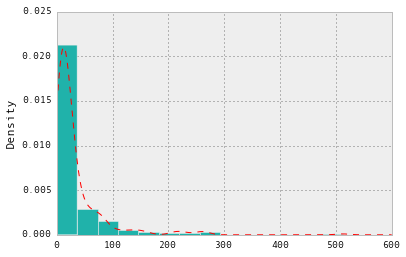

In [21]:
titanic.fare.hist(bins=doanes(titanic.fare.dropna()), normed=True, color='lightseagreen')
titanic.fare.dropna().plot(kind='kde', xlim=(0,600), style='r--')

Here, we had to normalize the histogram (`normed=True`), since the kernel density is normalized by definition (it is a probability distribution).

We will explore kernel density estimates more in the next section.

## Boxplots

A different way of visualizing the distribution of data is the boxplot, which is a display of common quantiles; these are typically the quartiles and the lower and upper 5 percent values.

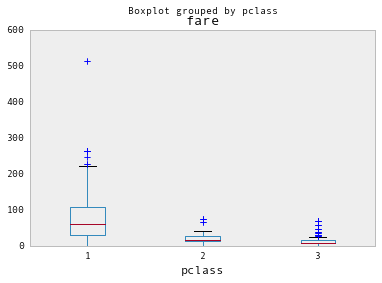

In [22]:
titanic.boxplot(column='fare', by='pclass', grid=False)

You can think of the box plot as viewing the distribution from above. The blue crosses are "outlier" points that occur outside the extreme quantiles.

One way to add additional information to a boxplot is to overlay the actual data; this is generally most suitable with small- or moderate-sized data series.

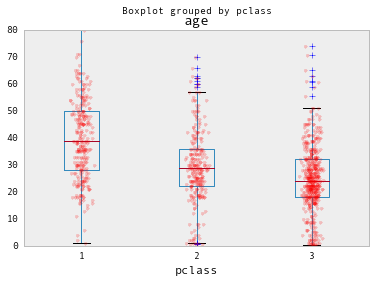

In [23]:
bp = titanic.boxplot(column='age', by='pclass', grid=False)
for i in [1,2,3]:
    y = titanic.age[titanic.pclass==i].dropna()
    # Add some random "jitter" to the x-axis
    x = np.random.normal(i, 0.04, size=len(y))
    plt.plot(x, y.values, 'r.', alpha=0.2)

When data are dense, a couple of tricks used above help the visualization:

1. reducing the alpha level to make the points partially transparent
2. adding random "jitter" along the x-axis to avoid overstriking

### Exercise

Using the Titanic data, create kernel density estimate plots of the age distributions of survivors and victims.

## Scatterplots

To look at how Pandas does scatterplots, let's reload the baseball sample dataset.

In [24]:
baseball = pd.read_csv("../data/baseball.csv")
baseball.head()

      id     player  year  stint team  lg   g  ab  r   h ...  rbi  sb  cs  bb  \
0  88641  womacto01  2006      2  CHN  NL  19  50  6  14 ...    2   1   1   4   
1  88643  schilcu01  2006      1  BOS  AL  31   2  0   1 ...    0   0   0   0   
2  88645  myersmi01  2006      1  NYA  AL  62   0  0   0 ...    0   0   0   0   
3  88649  helliri01  2006      1  MIL  NL  20   3  0   0 ...    0   0   0   0   
4  88650  johnsra05  2006      1  NYA  AL  33   6  0   1 ...    0   0   0   0   

   so  ibb  hbp  sh  sf  gidp  
0   4    0    0   3   0     0  
1   1    0    0   0   0     0  
2   0    0    0   0   0     0  
3   2    0    0   0   0     0  
4   4    0    0   0   0     0  

[5 rows x 23 columns]

Scatterplots are useful for data exploration, where we seek to uncover relationships among variables. There are no scatterplot methods for Series or DataFrame objects; we must instead use the matplotlib function `scatter`.

(0, 200)

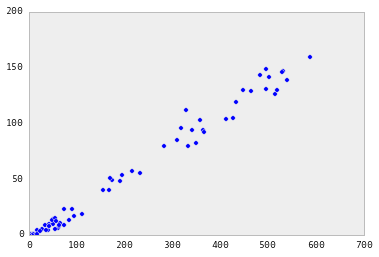

In [25]:
plt.scatter(baseball.ab, baseball.h)
plt.xlim(0, 700); plt.ylim(0, 200)

We can add additional information to scatterplots by assigning variables to either the size of the symbols or their colors.

(0, 200)

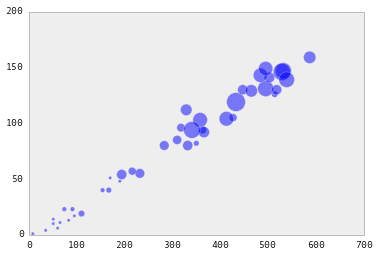

In [26]:
plt.scatter(baseball.ab, baseball.h, s=baseball.hr*10, alpha=0.5)
plt.xlim(0, 700); plt.ylim(0, 200)

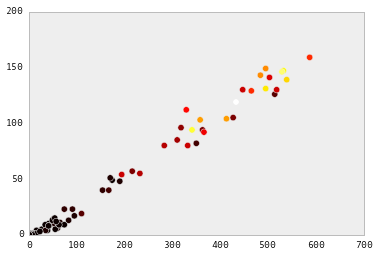

In [27]:
plt.scatter(baseball.ab, baseball.h, c=baseball.hr, s=40, cmap='hot')
plt.xlim(0, 700); plt.ylim(0, 200);

To view scatterplots of a large numbers of variables simultaneously, we can use the `scatter_matrix` function that was recently added to Pandas. It generates a matrix of pair-wise scatterplots, optiorally with histograms or kernel density estimates on the diagonal.

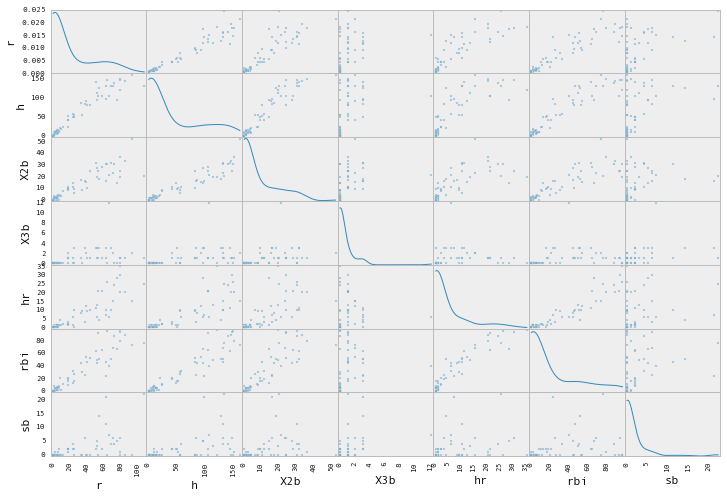

In [28]:
_ = pd.scatter_matrix(baseball.loc[:,'r':'sb'], figsize=(12,8), diagonal='kde')

## Trellis Plots

One of the enduring strengths of carrying out statistical analyses in the R language is the quality of its graphics. In particular, the addition of [Hadley Wickham's ggplot2 package](http://ggplot2.org) allows for flexible yet user-friendly generation of publication-quality plots. Its srength is based on its implementation of a powerful model of graphics, called the [Grammar of Graphics](http://vita.had.co.nz/papers/layered-grammar.pdf) (GofG). The GofG is essentially a theory of scientific graphics that allows the components of a graphic to be completely described. ggplot2 uses this description to build the graphic component-wise, by adding various layers.

Pandas recently added functions for generating graphics using a GofG approach. Chiefly, this allows for the easy creation of **trellis plots**, which are a faceted graphic that shows relationships between two variables, conditioned on particular values of other variables. This allows for the representation of more than two dimensions of information without having to resort to 3-D graphics, etc.


Let's use the `titanic` dataset to create a trellis plot that represents 4 variables at a time. This consists of 4 steps:

1. Create a `RPlot` object that merely relates two variables in the dataset
2. Add a grid that will be used to condition the variables by both passenger class and sex
3. Add the actual plot that will be used to visualize each comparison
4. Draw the visualization

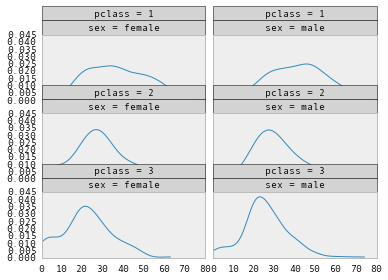

In [29]:
from pandas.tools.rplot import *

titanic = titanic[titanic.age.notnull() & titanic.fare.notnull()]

tp = RPlot(titanic, x='age')
tp.add(TrellisGrid(['pclass', 'sex']))
tp.add(GeomDensity())
_ = tp.render(plt.gcf())

Using the cervical dystonia dataset, we can simultaneously examine the relationship between age and the primary outcome variable as a function of both the treatment received and the week of the treatment by creating a scatterplot of the data, and fitting a polynomial relationship between `age` and `twstrs`:

In [30]:
cdystonia = pd.read_csv("../data/cdystonia.csv", index_col=None)
cdystonia.head()

   patient  obs  week  site  id  treat  age sex  twstrs
0        1    1     0     1   1  5000U   65   F      32
1        1    2     2     1   1  5000U   65   F      30
2        1    3     4     1   1  5000U   65   F      24
3        1    4     8     1   1  5000U   65   F      37
4        1    5    12     1   1  5000U   65   F      39

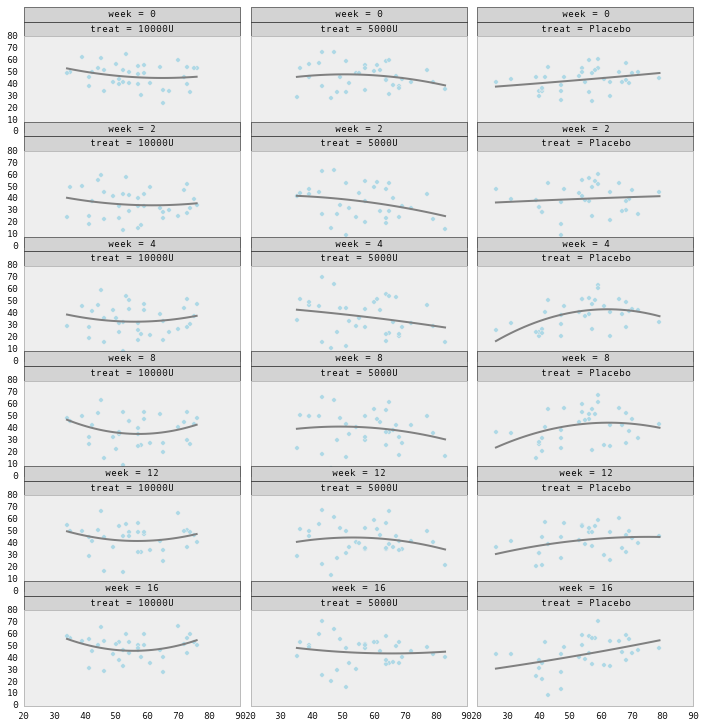

In [31]:
plt.figure(figsize=(12,12))
bbp = RPlot(cdystonia, x='age', y='twstrs')
bbp.add(TrellisGrid(['week', 'treat']))
bbp.add(GeomScatter())
bbp.add(GeomPolyFit(degree=2))
_ = bbp.render(plt.gcf())

We can use the `RPlot` class to represent more than just trellis graphics. It is also useful for displaying multiple variables on the same panel, using combinations of color, size and shapes to do so.

In [32]:
cdystonia['site'] = cdystonia.site.astype(float)

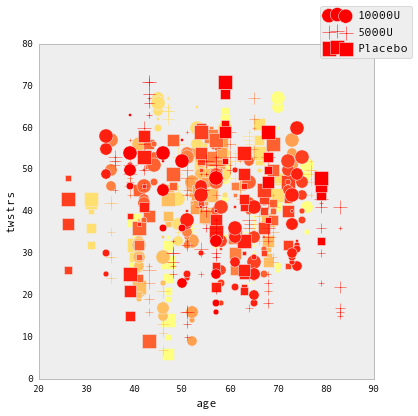

In [33]:
plt.figure(figsize=(6,6))
cp = RPlot(cdystonia, x='age', y='twstrs')
cp.add(GeomPoint(colour=ScaleGradient('site', colour1=(1.0, 1.0, 0.5), colour2=(1.0, 0.0, 0.0)),
            size=ScaleSize('week', min_size=10.0, max_size=200.0),
            shape=ScaleShape('treat')))
_ = cp.render(plt.gcf())